In [ ]:
!pip install numpy==1.24.4
!pip install torch==2.1.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118
!pip install pytorch-lightning==2.0.2
!pip install nemo_toolkit[all]==1.21.0
!pip install matplotlib

In [1]:
import torch
from nemo.collections.tts.models import FastPitchModel, HifiGanModel
import IPython.display as ipd
import matplotlib.pyplot as plt


In [ ]:
fastpitch = FastPitchModel.from_pretrained(model_name="tts_en_fastpitch").cuda().eval()
hifigan = HifiGanModel.from_pretrained(model_name="tts_en_hifigan").cuda().eval()

In [3]:
text = "Welcome to the speech synthesis demo."

#Generate mel spectrogram from text
with torch.no_grad():
    parsed = fastpitch.parse(text)
    spectrogram_pred = fastpitch.generate_spectrogram(tokens=parsed)

#Mel spectrogram shape
print("Mel spectrogram shape:", spectrogram_pred.shape)

Mel spectrogram shape: torch.Size([1, 80, 203])


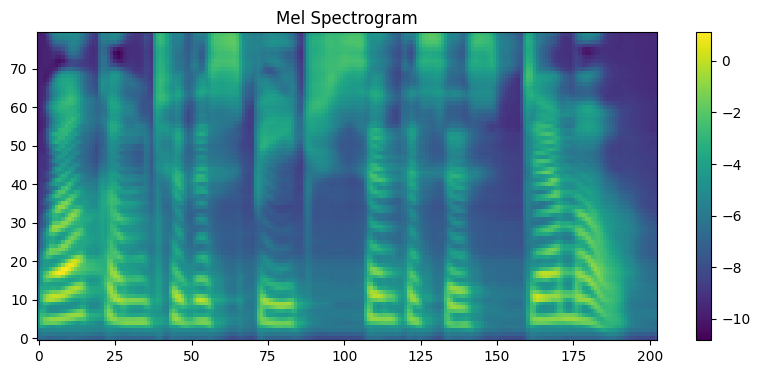

In [12]:
#Plot Mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_pred[0].cpu().numpy(), origin='lower', aspect='auto')
plt.title("Mel Spectrogram")
plt.colorbar()
plt.show()

In [13]:
#Generate waveform from spectrogram
with torch.no_grad():
    audio = hifigan.convert_spectrogram_to_audio(spec=spectrogram_pred)

ipd.display(ipd.Audio(audio.cpu().numpy(), rate=22050))

###Latency Evaluation

In [4]:
#Input texts
texts = {
    "Short": "Hello!",
    "Medium": "This is a medium-length sentence for FastPitch synthesis.",
    "Long": "FastPitch is a fast and controllable model that generates mel-spectrograms for high-quality speech synthesis with HiFiGAN."
}

In [7]:
import time

#Measure latency
latencies = {}

for label, text in texts.items():
    start = time.time()

    parsed = fastpitch.parse(text, normalize=True)
    spectrogram = fastpitch.generate_spectrogram(tokens=parsed)
    audio = hifigan.convert_spectrogram_to_audio(spec=spectrogram)

    _ = audio.detach().cpu().numpy()  # force execution
    end = time.time()
    latencies[label] = end - start


In [8]:
print("FastPitch + HiFiGAN (NeMo) Inference Times:")
for label, duration in latencies.items():
    print(f"{label}: {duration:.2f} seconds")

FastPitch + HiFiGAN (NeMo) Inference Times:
Short: 0.05 seconds
Medium: 0.13 seconds
Long: 0.16 seconds


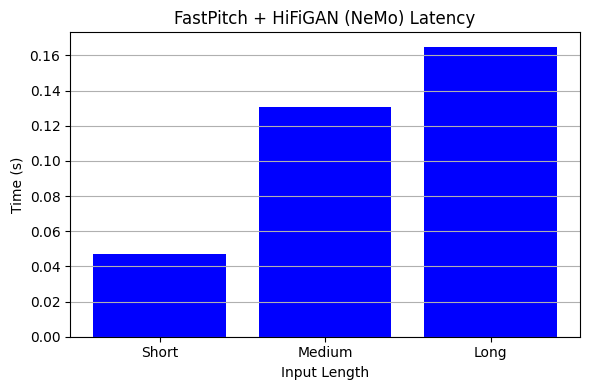

In [10]:
plt.figure(figsize=(6, 4))
plt.bar(latencies.keys(), latencies.values(), color='blue')
plt.title("FastPitch + HiFiGAN (NeMo) Latency")
plt.ylabel("Time (s)")
plt.xlabel("Input Length")
plt.grid(axis='y')
plt.tight_layout()
plt.show()